In [1]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# !pip install geopandas --quiet
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import scipy
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
# !pip install rasterio --quiet
import rasterio
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import math

2023-05-18 10:12:22.075209: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-18 10:12:22.077960: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-18 10:12:22.128420: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-18 10:12:22.129569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 10:12:23.448263: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
os.getcwd()
os.chdir('/home/shoyo/Desktop')
os.listdir( os.getcwd() )

['SOCoriginalTor.csv',
 'logs',
 'SOC_lonlatlandcover.csv',
 'python3-ipykernel_6.17.0-1_all(2).deb',
 '.ipynb_checkpoints',
 '.xdp_LSTM.ipynb.4SXV41',
 'LSTM',
 'Data.ipynb',
 'LSTM.ipynb',
 'SOClandsat6mTrue.csv',
 'RandomForest.ipynb']

In [3]:
# Set seed
def set_seed(seed: int = 42) -> None:
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

In [12]:
df2

,latitude,longitude,year,SOC,bushland,cropland,forest,grassland,mangrove,shrubland,...,wooded_grassland,woodland,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,EVI,ST_B10
171,1.431151,35.192894,2021.0,8.62885,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.577879,0.548963,0.549664,0.609490,0.349395,0.246669,3.814687,270.167100
231,1.361352,35.218496,2021.0,8.94760,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.485699,0.453936,0.460852,0.477737,0.210080,0.132695,7.565763,285.235441
285,1.392344,35.217687,2021.0,7.35775,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.264182,1.205113,1.217598,1.191060,0.629428,0.426092,-4.342934,254.080189
11805,-3.937451,32.998669,2021.0,3.98340,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.539764,0.561076,0.571251,0.659196,0.306564,0.259497,3.520754,245.964100
11823,-3.939337,32.994626,2021.0,2.26710,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.024575,0.967485,0.954835,0.935310,0.280398,0.271763,2.441541,201.969056
11829,-3.937990,32.997860,2021.0,4.90470,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.536258,0.543298,0.553390,0.657821,0.296760,0.247054,1.216397,250.334039
11841,-3.937181,32.999477,2021.0,3.56310,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.513955,0.543916,0.547780,0.637554,0.303360,0.248140,-6.318133,242.284602


In [17]:
csv_path = os.getcwd() + '/SOClandsat6mTrue.csv'
df1 = pd.read_csv(csv_path)
df2 = df1[ (df1.EVI<-1) | (df1.EVI>1) ]

df = pd.DataFrame(columns=df1.columns)
for i in range(len(df1)):
    lat = df1.loc[i, 'latitude']
    lon = df1.loc[i, 'longitude']
    if not ((df2['latitude'] == lat) & (df2['longitude'] == lon)).any():
        # df = pd.concat([df, df1.loc[i]]) 
        df.loc[len(df)] = df1.iloc[i]
        # df = df.append(df1.loc[i]) 

df = df.drop(columns=['latitude', 'longitude', 'year'])
df

,SOC,bushland,cropland,forest,grassland,mangrove,shrubland,thicket,wooded_grassland,woodland,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,EVI,ST_B10
0,6.84225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300885,0.348584,0.362017,0.474864,0.425474,0.354758,0.202733,288.696186
1,6.84225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095735,0.153705,0.163770,0.371642,0.354125,0.233125,0.317605,303.197136
2,6.84225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166671,0.191600,0.207811,0.356407,0.213353,0.192645,0.228537,236.222743
3,6.84225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.391195,0.382739,0.383000,0.508249,0.305120,0.206890,0.068306,283.094052
4,6.84225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.246600,0.280232,0.284247,0.357961,0.203893,0.175059,0.167163,233.638720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13477,13.22570,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040075,0.102803,0.092655,0.342272,0.235930,0.179720,0.358089,270.165391
13478,13.22570,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.169545,0.206367,0.209172,0.452987,0.324095,0.270855,0.424340,268.008620
13479,13.22570,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.351293,0.348598,0.342520,0.485382,0.212115,0.193140,0.374669,267.598458
13480,13.22570,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046812,0.111658,0.069060,0.385943,0.210080,0.142512,0.546647,260.598353


In [35]:
scaler = MinMaxScaler()
train_df = scaler.fit_transform(df[:11760])
val_df = scaler.fit_transform(df[11760:(11760+1464)])
test_df = scaler.fit_transform(df[(11760+1464):])

Xtrain = train_df[:,1:][::6]
# Xtrain = Xtrain.reshape((  int(len(Xtrain)/6), 6, 17))
Ytrain = train_df[:,0][::6]
#  [::6]
# Ytrain = Ytrain.reshape((len(Ytrain),1))

Xval = val_df[:,1:][::6]
# Xval = Xval.reshape((  int(len(Xval)/6), 6, 17))
Yval = val_df[:,0][::6]
#  [::6]
# Yval = Yval.reshape((len(Yval),1))

Xtest = test_df[:,1:][::6]
# Xtest = Xtest.reshape((  int(len(Xtest)/6), 6, 17))
Ytest = test_df[:,0][::6]
#  [::6]
# Ytest = Ytest.reshape((len(Ytest),1))

In [36]:
# Set grid search parameters
n_trees_range = [50, 100, 200, 300, 400, 500]
min_samples_range = [50, 150, 300, 450, 600, 750]

# prepare matrix for storing the matrics reached on the validation set per parameter combination
rmse_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])
mae_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])
rsquare_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])

# the time it takes to train models
time_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])

from datetime import datetime
# Perform the parameter searching and keep track of performance
for n_trees_index, n_trees in enumerate(n_trees_range):
    for min_leaves_index, min_samples in enumerate(min_samples_range):
        print(f"N trees: {n_trees}, Min. samples samples per leaf: {min_samples}")
        
        # Initialize the random forest classifier
        model = RandomForestRegressor(n_estimators=n_trees, min_samples_split=min_samples)
        
        # Fit the classifier to the training data/labels
        start = datetime.now()
        model.fit(Xtrain, Ytrain)
        end = datetime.now()
        time_taken = float(f"{(end - start).seconds}.{round((end - start).microseconds, 2)}")

        # Use the model to predict all of the validation pixels
        predictions = model.predict(Xval)

        # Calculate the accuracy of the predicted labels vs the ground truth labels
        rmse = math.sqrt( mean_squared_error(predictions, Yval) )
        mae = mean_absolute_error(predictions, Yval)
        rsquared = r2_score(predictions, Yval)

        # Store accuracies and time taken for this parameter combination
        rmse_paramsearch[n_trees_index, min_leaves_index] = round(rmse, 1)
        mae_paramsearch[n_trees_index, min_leaves_index] = round(mae, 1)
        rsquare_paramsearch[n_trees_index, min_leaves_index] = round(rsquared, 1)
        time_paramsearch[n_trees_index, min_leaves_index] = round(time_taken, 1)

N trees: 50, Min. samples samples per leaf: 50
N trees: 50, Min. samples samples per leaf: 150
N trees: 50, Min. samples samples per leaf: 300
N trees: 50, Min. samples samples per leaf: 450
N trees: 50, Min. samples samples per leaf: 600
N trees: 50, Min. samples samples per leaf: 750
N trees: 100, Min. samples samples per leaf: 50
N trees: 100, Min. samples samples per leaf: 150
N trees: 100, Min. samples samples per leaf: 300
N trees: 100, Min. samples samples per leaf: 450
N trees: 100, Min. samples samples per leaf: 600
N trees: 100, Min. samples samples per leaf: 750
N trees: 200, Min. samples samples per leaf: 50
N trees: 200, Min. samples samples per leaf: 150
N trees: 200, Min. samples samples per leaf: 300
N trees: 200, Min. samples samples per leaf: 450
N trees: 200, Min. samples samples per leaf: 600
N trees: 200, Min. samples samples per leaf: 750
N trees: 300, Min. samples samples per leaf: 50
N trees: 300, Min. samples samples per leaf: 150
N trees: 300, Min. samples sam

/tmp/ipykernel_259893/3546025900.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_rmse.set_xticklabels(n_trees_labels)
/tmp/ipykernel_259893/3546025900.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_rmse.set_yticklabels(min_leaves_labels)
/tmp/ipykernel_259893/3546025900.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_mae.set_xticklabels(n_trees_labels)
/tmp/ipykernel_259893/3546025900.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_mae.set_yticklabels(min_leaves_labels)
/tmp/ipykernel_259893/3546025900.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_rsquared.set_xticklabels(n_trees_labels)
/tmp/ipykernel_259893/3546025900.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_rsquared.set_yticklabels(min_leaves_labels)
/tmp/ipykernel_259893/3546025900.py:31: Use

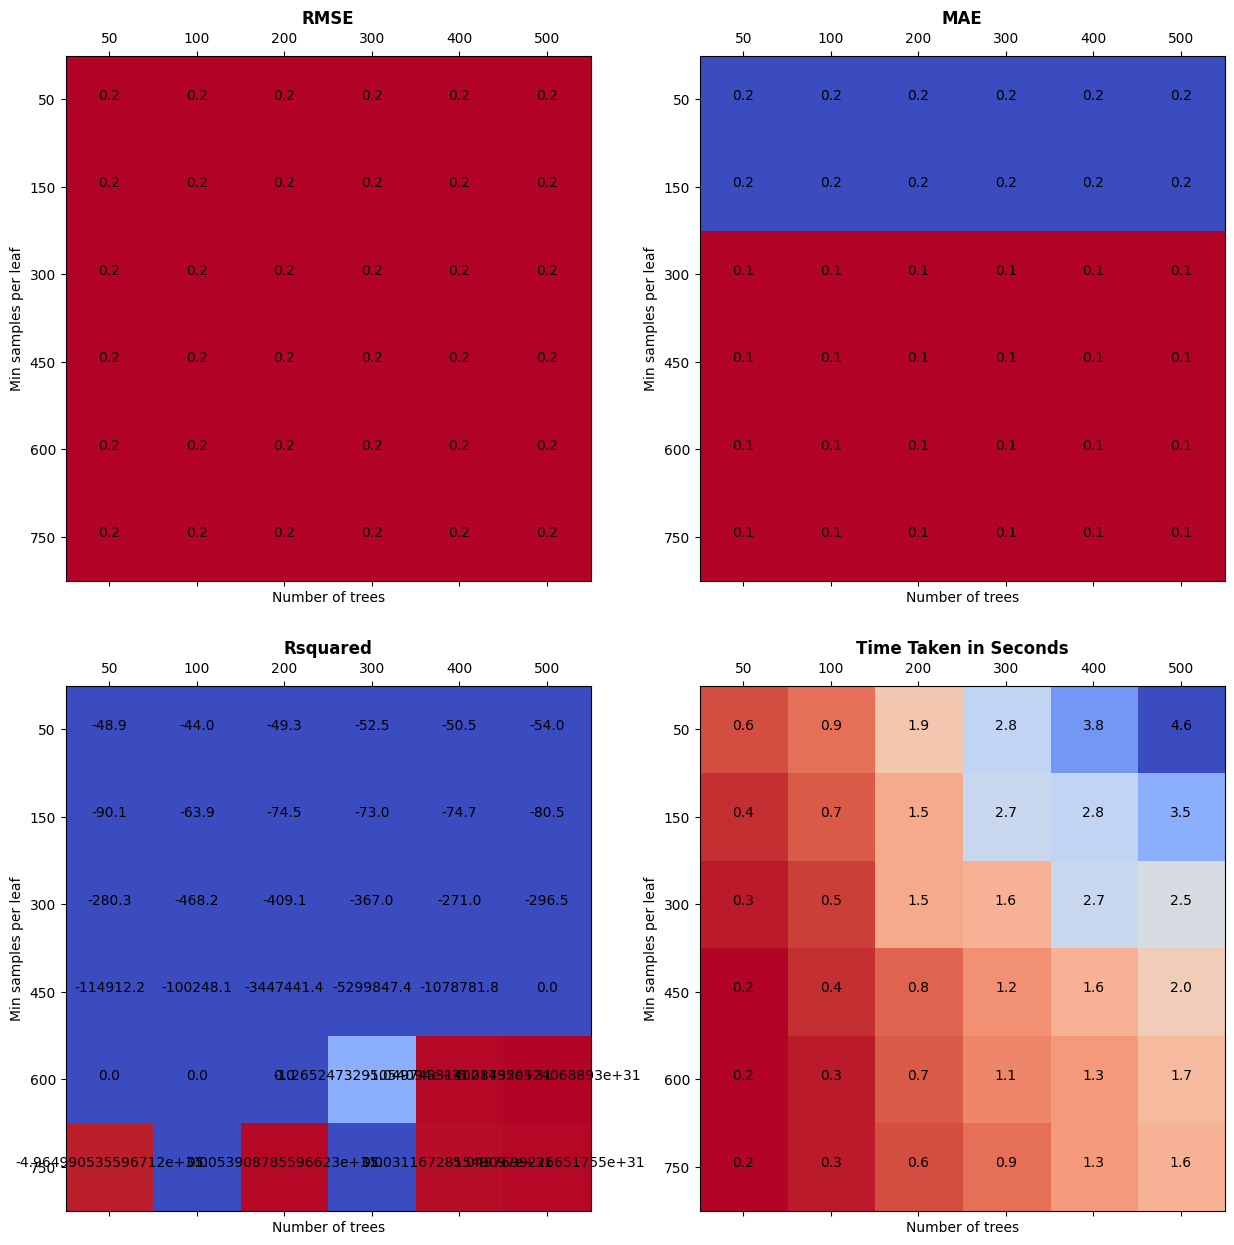

In [30]:
# Plot the validation results
n_trees_labels = [0] + n_trees_range
min_leaves_labels = [0] + min_samples_range 

fig, ((ax_rmse, ax_mae), (ax_rsquared, ax_time)) = plt.subplots(2, 2, figsize=(15,15))

## Plot accuracy
ax_rmse.set_title("RMSE", weight='bold')
ax_rmse.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_rmse.set_xticklabels(n_trees_labels)
ax_rmse.set_yticklabels(min_leaves_labels)
ax_rmse.matshow(rmse_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Plot precision
ax_mae.set_title("MAE", weight='bold')
ax_mae.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_mae.set_xticklabels(n_trees_labels)
ax_mae.set_yticklabels(min_leaves_labels)
ax_mae.matshow(mae_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Plot recall
ax_rsquared.set_title("Rsquared", weight='bold')
ax_rsquared.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_rsquared.set_xticklabels(n_trees_labels)
ax_rsquared.set_yticklabels(min_leaves_labels)
ax_rsquared.matshow(rsquare_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Plot time taken
ax_time.set_title("Time Taken in Seconds", weight='bold')
ax_time.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_time.set_xticklabels(n_trees_labels)
ax_time.set_yticklabels(min_leaves_labels)
ax_time.matshow(time_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Add text to plots
for t_i, t_val in enumerate(n_trees_range):
    for l_i, l_val in enumerate(min_samples_range):
        ax_rmse.text(t_i, l_i, s=rmse_paramsearch[t_i, l_i], ha='center')
        ax_mae.text(t_i, l_i, s=mae_paramsearch[t_i, l_i], ha='center')
        ax_rsquared.text(t_i, l_i, s=rsquare_paramsearch[t_i, l_i], ha='center')
        ax_time.text(t_i, l_i, s=time_paramsearch[t_i, l_i], ha='center')

In [37]:
model = RandomForestRegressor(n_estimators=n_trees, min_samples_split=min_samples)
model.fit(Xtrain, Ytrain)
Ypred = model.predict(Xtest)

In [38]:
mse = mean_squared_error(Ypred, Ytest)
print("RMSE", math.sqrt(mse))
mae = mean_absolute_error(Ypred, Ytest)
print("MAE", mae)
R_square = r2_score(Ypred, Ytest) 
print('Coefficient of Determination', R_square) 

RMSE 0.4400962948008862
MAE 0.36502863710944966
Coefficient of Determination -131.22095155376346


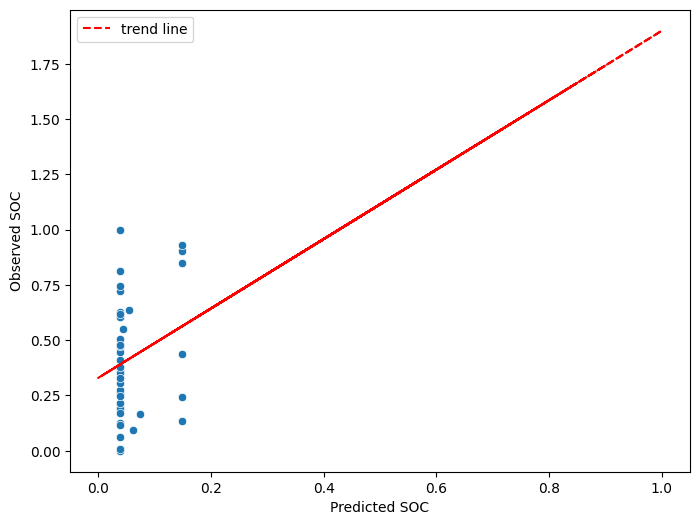

In [39]:
scatterplot=sns.scatterplot(x=np.squeeze(Ypred), y=np.squeeze(Ytest))
z = np.polyfit(np.squeeze(Ypred), np.squeeze(Ytest), 1)  #Least squares polynomial fit.
p = np.poly1d(z)                           #A one-dimensional polynomial class.
scatterplot.plot(np.squeeze(Ytest), p(np.squeeze(Ytest)), "r--", label='trend line')
plt.legend()
plt.xlabel("Predicted SOC")
plt.ylabel("Observed SOC")
plt.show()